In [1]:
import pandas as pd

In [2]:
df_demo = pd.read_csv("demographic_updates_full.csv")
df_enrol = pd.read_csv("enrolment_full.csv")

In [3]:
df_demo['date'] = pd.to_datetime(df_demo['date'], format='%d-%m-%Y')
df_enrol['date'] = pd.to_datetime(df_enrol['date'], format='%d-%m-%Y')

In [5]:
# Missing values
df_demo.isna().sum()
df_enrol.isna().sum()


date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64

In [6]:
# Duplicates
df_demo.duplicated().sum()
df_enrol.duplicated().sum()

np.int64(22957)

In [7]:
# Unique geography counts
df_demo['state'].nunique(), df_demo['district'].nunique()
df_enrol['state'].nunique(), df_enrol['district'].nunique()

(55, 985)

In [8]:
df_demo['total_updates'] = (
    df_demo['demo_age_5_17'] +
    df_demo['demo_age_17_']
)

df_enrol['total_enrolments'] = (
    df_enrol['age_0_5'] +
    df_enrol['age_5_17'] +
    df_enrol['age_18_greater']
)


In [9]:
demo_dist = df_demo.groupby(
    ['state', 'district']
).agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'total_updates': 'sum'
}).reset_index()

enrol_dist = df_enrol.groupby(
    ['state', 'district']
).agg({
    'total_enrolments': 'sum'
}).reset_index()


In [10]:
merged_dist = demo_dist.merge(
    enrol_dist,
    on=['state', 'district'],
    how='left'
)


In [11]:
merged_dist['update_enrol_ratio'] = (
    merged_dist['total_updates'] /
    merged_dist['total_enrolments']
)


In [12]:
print("demo dist shape",demo_dist.shape)
print("enrol dist shape",enrol_dist.shape)
print("merged dist shape",merged_dist.shape)

demo dist shape (1078, 5)
enrol dist shape (1070, 3)
merged dist shape (1078, 7)


In [13]:
merged_dist[['state','district','total_updates','total_enrolments','update_enrol_ratio']].head()

,state,district,total_updates,total_enrolments,update_enrol_ratio
0,100000,100000,2,218.0,0.009174
1,Andaman & Nicobar Islands,Andamans,750,75.0,10.000000
2,Andaman & Nicobar Islands,Nicobars,4,1.0,4.000000
3,Andaman & Nicobar Islands,South Andaman,305,38.0,8.026316
4,Andaman and Nicobar Islands,Nicobar,787,75.0,10.493333


In [14]:
# Keep only valid state names (string-based)
df_demo = df_demo[df_demo['state'].apply(lambda x: isinstance(x, str))]
df_enrol = df_enrol[df_enrol['state'].apply(lambda x: isinstance(x, str))]


In [15]:
df_demo = df_demo[df_demo['district'].apply(lambda x: isinstance(x, str))]
df_enrol = df_enrol[df_enrol['district'].apply(lambda x: isinstance(x, str))]


In [16]:
df_demo['total_updates'] = df_demo['demo_age_5_17'] + df_demo['demo_age_17_']
df_enrol['total_enrolments'] = (
    df_enrol['age_0_5'] +
    df_enrol['age_5_17'] +
    df_enrol['age_18_greater']
)

demo_dist = df_demo.groupby(['state', 'district']).agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'total_updates': 'sum'
}).reset_index()

enrol_dist = df_enrol.groupby(['state', 'district']).agg({
    'total_enrolments': 'sum'
}).reset_index()

merged_dist = demo_dist.merge(
    enrol_dist,
    on=['state', 'district'],
    how='left'
)

merged_dist['update_enrol_ratio'] = (
    merged_dist['total_updates'] /
    merged_dist['total_enrolments']
)


In [17]:
analysis_df = merged_dist[
    merged_dist['total_enrolments'] >= 50
].copy()


<Axes: title={'center': 'Distribution of Aadhaar Demographic Updates by Age Group'}>

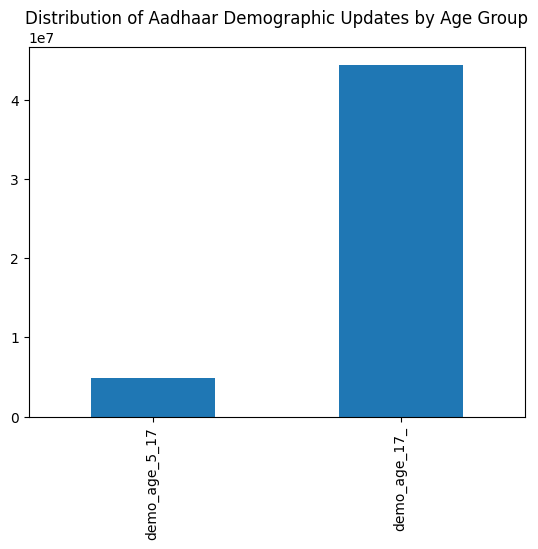

In [18]:
df_demo[['demo_age_5_17','demo_age_17_']].sum().plot(
    kind='bar',
    title='Distribution of Aadhaar Demographic Updates by Age Group'
)


<Axes: title={'center': 'Top 10 Districts by Demographic Update Volume'}, ylabel='district'>

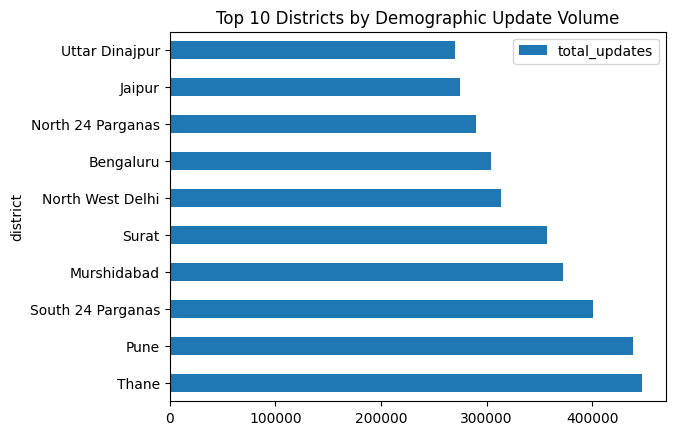

In [19]:
analysis_df.sort_values(
    'total_updates', ascending=False
).head(10).plot(
    x='district',
    y='total_updates',
    kind='barh',
    title='Top 10 Districts by Demographic Update Volume'
)


<Axes: title={'center': 'Districts with Highest Update-to-Enrolment Ratios'}, xlabel='district'>

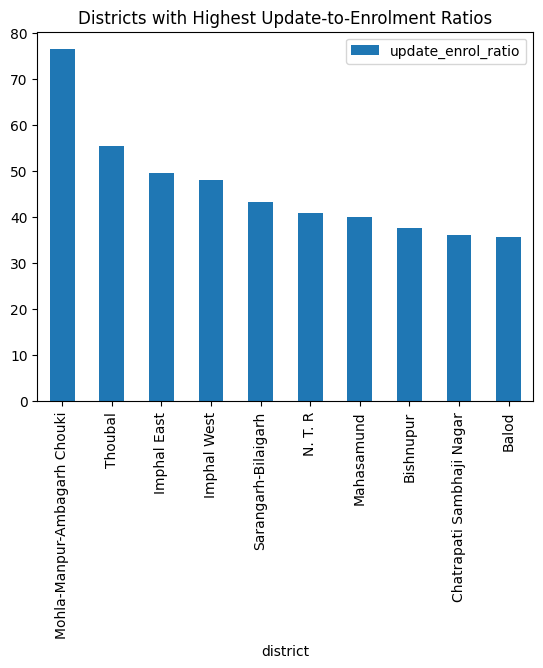

In [20]:
analysis_df.sort_values(
    'update_enrol_ratio', ascending=False
).head(10)[['district','update_enrol_ratio']].plot(
    x='district',
    y='update_enrol_ratio',
    kind='bar',
    title='Districts with Highest Update-to-Enrolment Ratios'
)


In [21]:
import numpy as np

analysis_df['z_score'] = (
    (analysis_df['total_updates'] - analysis_df['total_updates'].mean()) /
    analysis_df['total_updates'].std()
)

outliers = analysis_df[analysis_df['z_score'].abs() > 2]


In [24]:
analysis_df = analysis_df[
    analysis_df['state'].apply(lambda x: isinstance(x, str)) &
    analysis_df['district'].apply(lambda x: isinstance(x, str))
]


In [25]:
analysis_df['adult_update_share'] = (
    analysis_df['demo_age_17_'] /
    analysis_df['total_updates']
)

analysis_df.sort_values(
    'adult_update_share', ascending=False
).head(10)


,state,district,demo_age_5_17,demo_age_17_,total_updates,total_enrolments,update_enrol_ratio,z_score,adult_update_share
549,Maharashtra,Nandurbar *,0,600,600,140.0,4.285714,-0.867537,1.000000
0,100000,100000,0,2,2,218.0,0.009174,-0.877173,1.000000
809,Tamil Nadu,Kanchipuram,0,8,8,387.0,0.020672,-0.877076,1.000000
1035,West Bengal,Koch Bihar,427,70660,71087,3348.0,21.232676,0.268180,0.993993
1018,West Bengal,Darjiling,58,8213,8271,726.0,11.392562,-0.743939,0.992988
1025,West Bengal,Haora,354,39541,39895,2862.0,13.939553,-0.234399,0.991127
731,Punjab,Nawanshahr,27,2931,2958,192.0,15.406250,-0.829544,0.990872
1,Andaman & Nicobar Islands,Andamans,7,743,750,75.0,10.000000,-0.865120,0.990667
557,Maharashtra,Raigarh(MH),8,845,853,88.0,9.693182,-0.863461,0.990621
942,Uttar Pradesh,Jyotiba Phule Nagar,6,599,605,84.0,7.202381,-0.867457,0.990083


In [28]:
analysis_df[['state','district']].head()


,state,district
1,Andaman & Nicobar Islands,Andamans
4,Andaman and Nicobar Islands,Nicobar
5,Andaman and Nicobar Islands,North And Middle Andaman
6,Andaman and Nicobar Islands,South Andaman
7,Andhra Pradesh,Adilabad


In [27]:
analysis_df = analysis_df[
    ~(
        analysis_df['state'].str.match(r'^\d+$') |
        analysis_df['district'].str.match(r'^\d+$')
    )
]


In [29]:
analysis_df[['state','district']].head(10)
analysis_df['state'].str.match(r'^\d+$').sum()
analysis_df['district'].str.match(r'^\d+$').sum()


np.int64(0)

In [30]:
analysis_df.to_csv(
    "final_analysis_district_level.csv",
    index=False
)


In [31]:
analysis_df.shape
analysis_df['state'].nunique()
analysis_df['district'].nunique()

analysis_df['adult_update_share'].describe()
analysis_df['update_enrol_ratio'].describe()


count    904.000000
mean      10.862746
std        7.178838
min        0.020672
25%        6.693449
50%        9.622139
75%       13.077326
max       76.490347
Name: update_enrol_ratio, dtype: float64

In [34]:
analysis_df['state'].nunique()


42